In [1]:
import loompy as lp
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scanpy as sc
from scipy.sparse import csr_matrix
import seaborn as sns
from tdigest import TDigest
from tqdm.notebook import tqdm

/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/loompy/bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/loompy/bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/loompy/bus_f

In [2]:
# Helper functions
def read_list(path):
    with open(path) as handle:
        return [ l.strip() for l in handle.readlines() ]

def print_cell_and_gene_counts(anndata: dict) -> None:
    total_cells = sum([ d.shape[0] for d in anndata.values() ])
    print(f"Total number of cells in {len(anndata.keys())} datasets:", 
          total_cells)

    gene_intersect = idx_union(*[ d.var for d in anndata.values() ])
    print(f"Total number of genes in {len(anndata.keys())} datasets:", 
          len(gene_intersect))

def filter_by_std(data, field, factor=3):
    mean = data.obs[field].mean()
    std = data.obs[field].std()
    bottom = mean - factor * std
    top = mean + factor * std
    print(f"Mean {round(mean, 2)}   Standard deviation {round(std, 2)}")
    return data[(data.obs[field] >= bottom) & (data.obs[field] <= top)]

def idx_intersection(*sets):
    intersection = set(sets[0].index)
    for s in sets:
        intersection &= set(s.index)
    return intersection

def idx_union(*sets):
    intersection = set()
    for s in sets:
        intersection |= set(s.index)
    return intersection

def grid_kdeplots(data, get_arr_fn):
    ncols = 3
    nrows = math.ceil(len(data.keys()) / ncols)
    sns.set()
    sns.set_style("whitegrid", { "grid.linestyle": ":" })
    _fig, axes = plt.subplots(nrows=nrows, ncols=3, 
                              figsize=(5 * ncols, 5 * nrows))

    for idx, (k, d) in enumerate(data.items()):
        arr = get_arr_fn(d)
        sns.kdeplot(arr, fill=True, legend=False,
                    ax=axes[idx // ncols, idx % ncols]).set(title=k)

In [3]:
# Global variables
MODEL_INPUT_SIZE = 2**11 # 2048
print("Model input size:", MODEL_INPUT_SIZE)

PROTEIN_CODING_GENES = read_list("./protein_coding_BioMart.txt")
print("Number of protein coding genes:", len(PROTEIN_CODING_GENES))

RATIO_MITO_THRES = 0.1 # 10% mitochondria count

# Percentile thresholds used to discretize gene expression values
PERCENTILE_THRESHOLDS = [33.333, 66.666]

Model input size: 2048
Number of protein coding genes: 13986


In [4]:
# Write TOKEN DICTIONARY
token_dict = { "<pad>": 0, "<mask>": 1, 
              **{g: idx+2 for idx, g in enumerate(PROTEIN_CODING_GENES) } }
print("Vocabulary length:", len(token_dict.keys()))

with open("./TOKEN_DICT.pkl", "wb") as handle:
    pickle.dump(token_dict, handle)

Vocabulary length: 13988


In [5]:
# Seaborn customization
sns.set_style("whitegrid", { "grid.linestyle": ":" })

# 1. Load data in Scanpy (AnnData)  `-> anndata`

## A - s_fca_biohub_all_wo_blood_10x

In [6]:
def read_fca():
    # Convert to AnnData from loom when non-canonical loom format
    loom_file = "./scRNA-seq/s_fca_biohub_all_wo_blood_10x.loom"
    with lp.connect(loom_file, validate=False) as data:
        obs = pd.DataFrame(data=zip(data.ca["CellID"], 
                                    data.ca["n_counts"],
                                    data.ca["percent_mito"]),
                            columns=["obs_names", "total_counts", 
                                     "percent_mito"])
        adata = sc.AnnData(X=data.sparse().T, obs=obs, var=data.ra["Gene"])

    # Format AnnData to follow standard format
    # Convert coo sparse matrix to csr (allows slicing)
    adata.X = adata.X.tocsr()
    # Format obs and var fields (index appropriately)
    # adata.obs.columns = ["obs_names"]
    adata.var.columns = ["var_names"]
    adata.var.set_index("var_names", inplace=True, drop=False)
    adata.obs.set_index("obs_names", inplace=True, drop=False)
    
    # Normalize cell count to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4, key_added="norm_factor")
    # Log1p transform
    sc.pp.log1p(adata)

    # Mitochondrial gene ratio
    adata.obs["ratio_mito"] = adata.obs.percent_mito

    return adata

## B - afca.adata_headBody_S_v1.0

In [7]:
def read_afca():
    loom_file = "afca.adata_headBody_S_v1.0.loom"
    adata = sc.read_loom(f"./scRNA-seq/{loom_file}")

    # Make sure both obs_names (cells) and 
    # var_names (genes) are row and col indices
    adata.obs_names = adata.obs.obs_names
    adata.var_names = adata.var.var_names

    # Mitochondrial gene ratio
    adata.obs["ratio_mito"] = adata.obs["pct_counts_mt"] / 100

    return adata

## C - Davie 2018

In [8]:
def read_davie():
    loom_file = "Davie_Janssens_Koldere_et_al_2018_AdultBrain.loom"
    with lp.connect(f"./scRNA-seq/{loom_file}", validate=False) as data:
        obs = pd.DataFrame(data=zip(data.ca["CellID"], 
                                    data.ca["n_counts"],
                                    data.ca["percent_mito"]),
                            columns=["obs_names", "total_counts", 
                                     "percent_mito"])
        var = pd.DataFrame(data.ra["Gene"])
        var.columns = ["var_names"]
        adata = sc.AnnData(X=data.sparse().T, obs=obs, var=var)
    # Format AnnData to follow standard format
    # Convert coo sparse matrix to csr (allows slicing)
    adata.X = adata.X.tocsr()

    # Normalize to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4, key_added="norm_factor")
    # Log1p transform
    sc.pp.log1p(adata)

    # Format obs and var fields (index appropriately)
    # adata.obs.columns = ["obs_names"]
    adata.var.columns = ["var_names"]
    adata.var.set_index("var_names", inplace=True, drop=False)
    adata.obs.set_index("obs_names", inplace=True, drop=False)

    # Mitochondrial gene ratio
    adata.obs["ratio_mito"] = adata.obs.percent_mito

    return adata

## D - Ozel 2020. GSE142787

In [9]:
def read_ozel():
    ozel = {}
    for suffix in [ "Adult", "P15", "P30", "P40", "P50", "P70" ]:
        loom_file = f"GSE142787_{suffix}.loom"
        adata = sc.read_loom(f"./scRNA-seq/GSE142787/loom/{loom_file}")

        adata.var["var_names"] = adata.var.index
        adata.var_names = adata.var.var_names
        adata.obs["obs_names"] = adata.obs.index
        adata.obs_names = adata.obs.obs_names

        # Reconvert to counts (it was log transformed by authors)
        adata.X = csr_matrix(np.exp(adata.X.toarray()))
        # Normalize to 10,000
        sc.pp.normalize_total(adata, target_sum=1e4, key_added="norm_factor")
        # Log1p transform
        sc.pp.log1p(adata)

        # Mitochondrial gene ratio
        if "percent.mito" in adata.obs.keys():
            adata.obs["ratio_mito"] = adata.obs["percent.mito"]
        else:
            mito_genes = adata.var_names.str.startswith('mt:')
            mito_data = adata[:, mito_genes].X.toarray()
            adata.obs["ratio_mito"] = np.expm1(mito_data).sum(axis=1) /\
                                      np.expm1(adata.X.toarray()).sum(axis=1)

        ozel[f"ozel_{suffix}"] = adata
    return ozel

## E - Konstantinides (Ozel) 2022. GSE142787 

In [10]:
def read_GSE167266():
    loom_file = f"GSE167266_OL.L3_P15_merged.loom"
    adata = sc.read_loom(f"./scRNA-seq/{loom_file}")

    adata.var["var_names"] = adata.var.index
    adata.var_names = adata.var.var_names
    adata.obs["obs_names"] = adata.obs.index
    adata.obs_names = adata.obs.obs_names

    # Mitochondrial gene ratio
    mito_genes = adata.var_names.str.startswith('mt:')
    mito_data = adata[:, mito_genes].layers["counts"].toarray()
    adata.obs["ratio_mito"] = mito_data.sum(axis=1) / \
        adata.layers["counts"].toarray().sum(axis=1)
    return adata

## `Read data into dictionary -> anndata`

In [19]:
anndata = {
    "fca": read_fca(),
    "afca": read_afca(),
    "davie": read_davie(),
    **read_ozel(),
}

/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
# Create expm1 layers for further QC and normalization
for d in anndata.values():
    d.layers["expm1"] = csr_matrix(np.expm1(d.X.toarray()))

# 2. QC plots (gene expression, cell normalization and log1p transformation)

## Gene expression profile and std

In [70]:
# Compute gene's standard deviation log1p gene expression to plot
gene_std = { k: np.std(d.X.toarray(), axis=0) for k,d in anndata.items() }

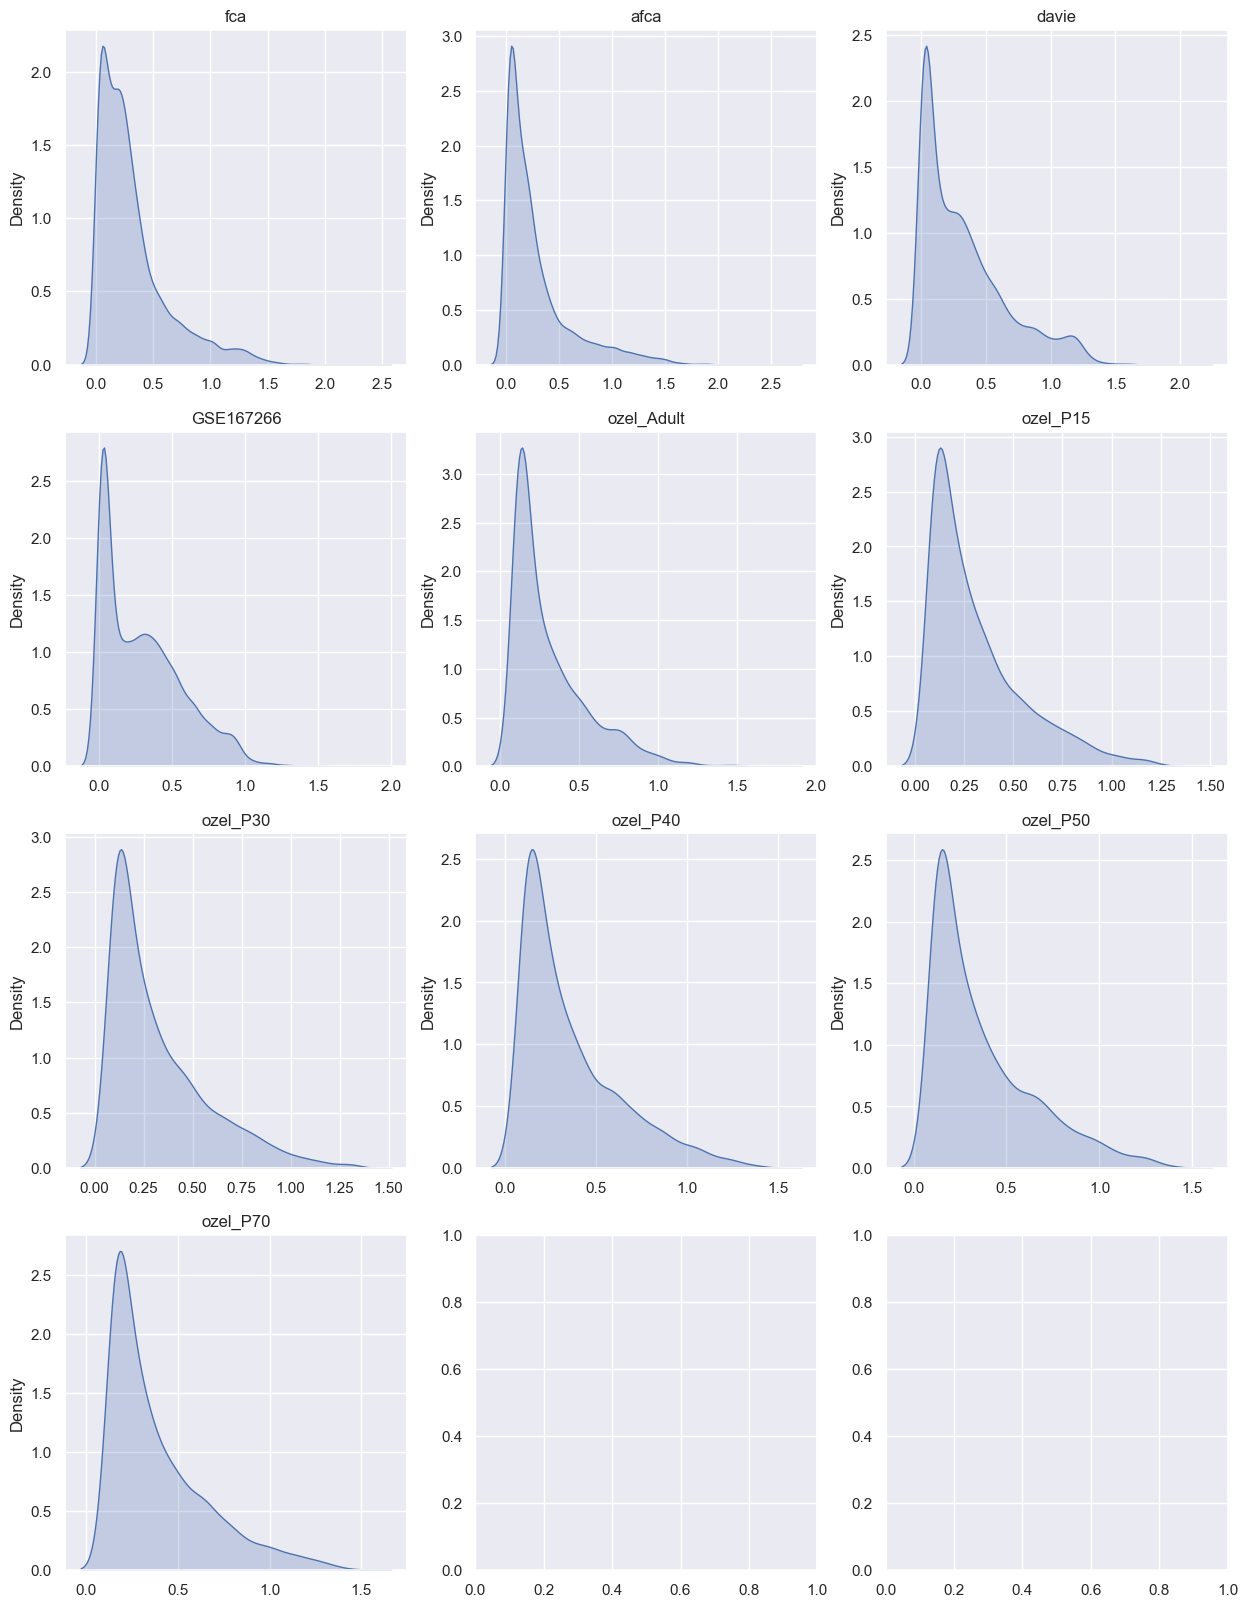

In [71]:
# Plot every gene expression standard deviation across datasets
grid_kdeplots(gene_std, lambda d: d)

780 Ccn


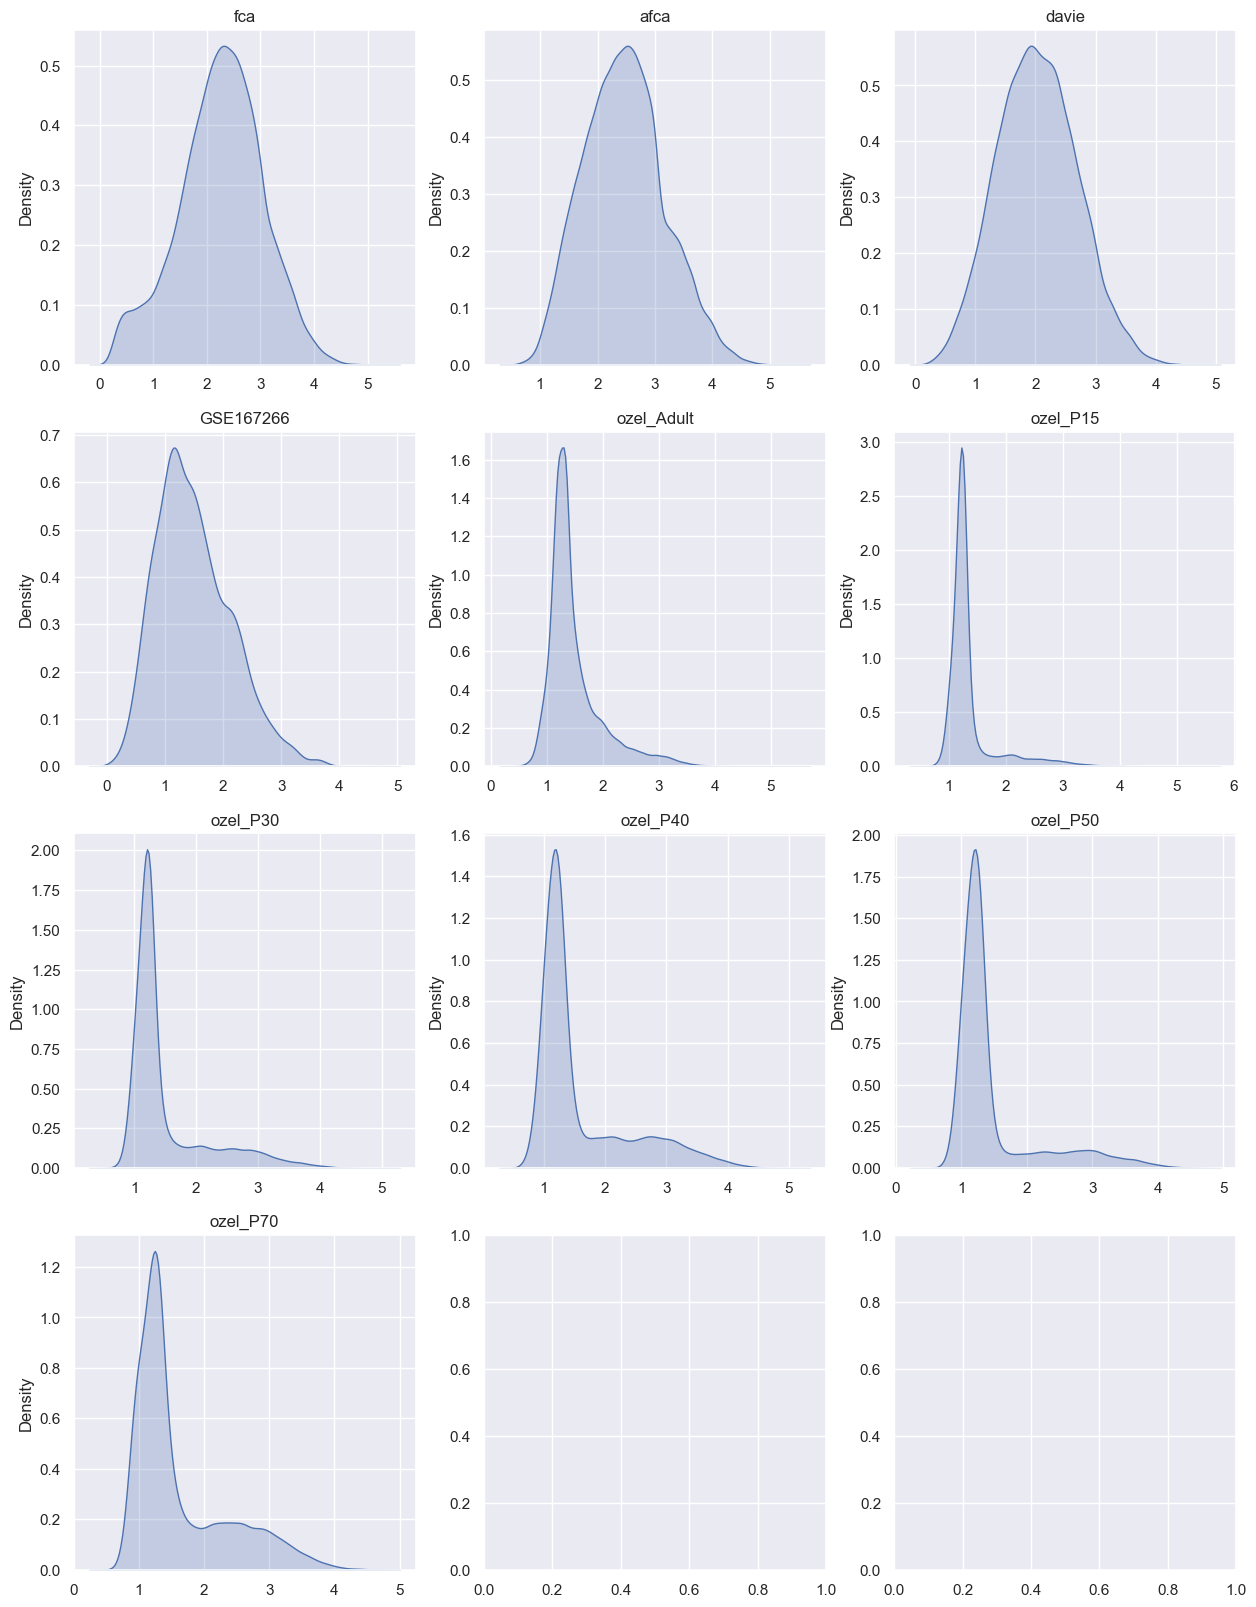

In [72]:
# Plot gene expression in every dataset (gene is in all datasets)
gene_intersect = idx_intersection(*[ d.var for d in anndata.values() ])
example_gene = list(gene_intersect)[0]
print(len(gene_intersect), example_gene) # "Hsp23"
grid_kdeplots(anndata, lambda d: np.asarray(d[:, example_gene].X.data))

## Assert cell 1e-4 normalization (revert log1p)

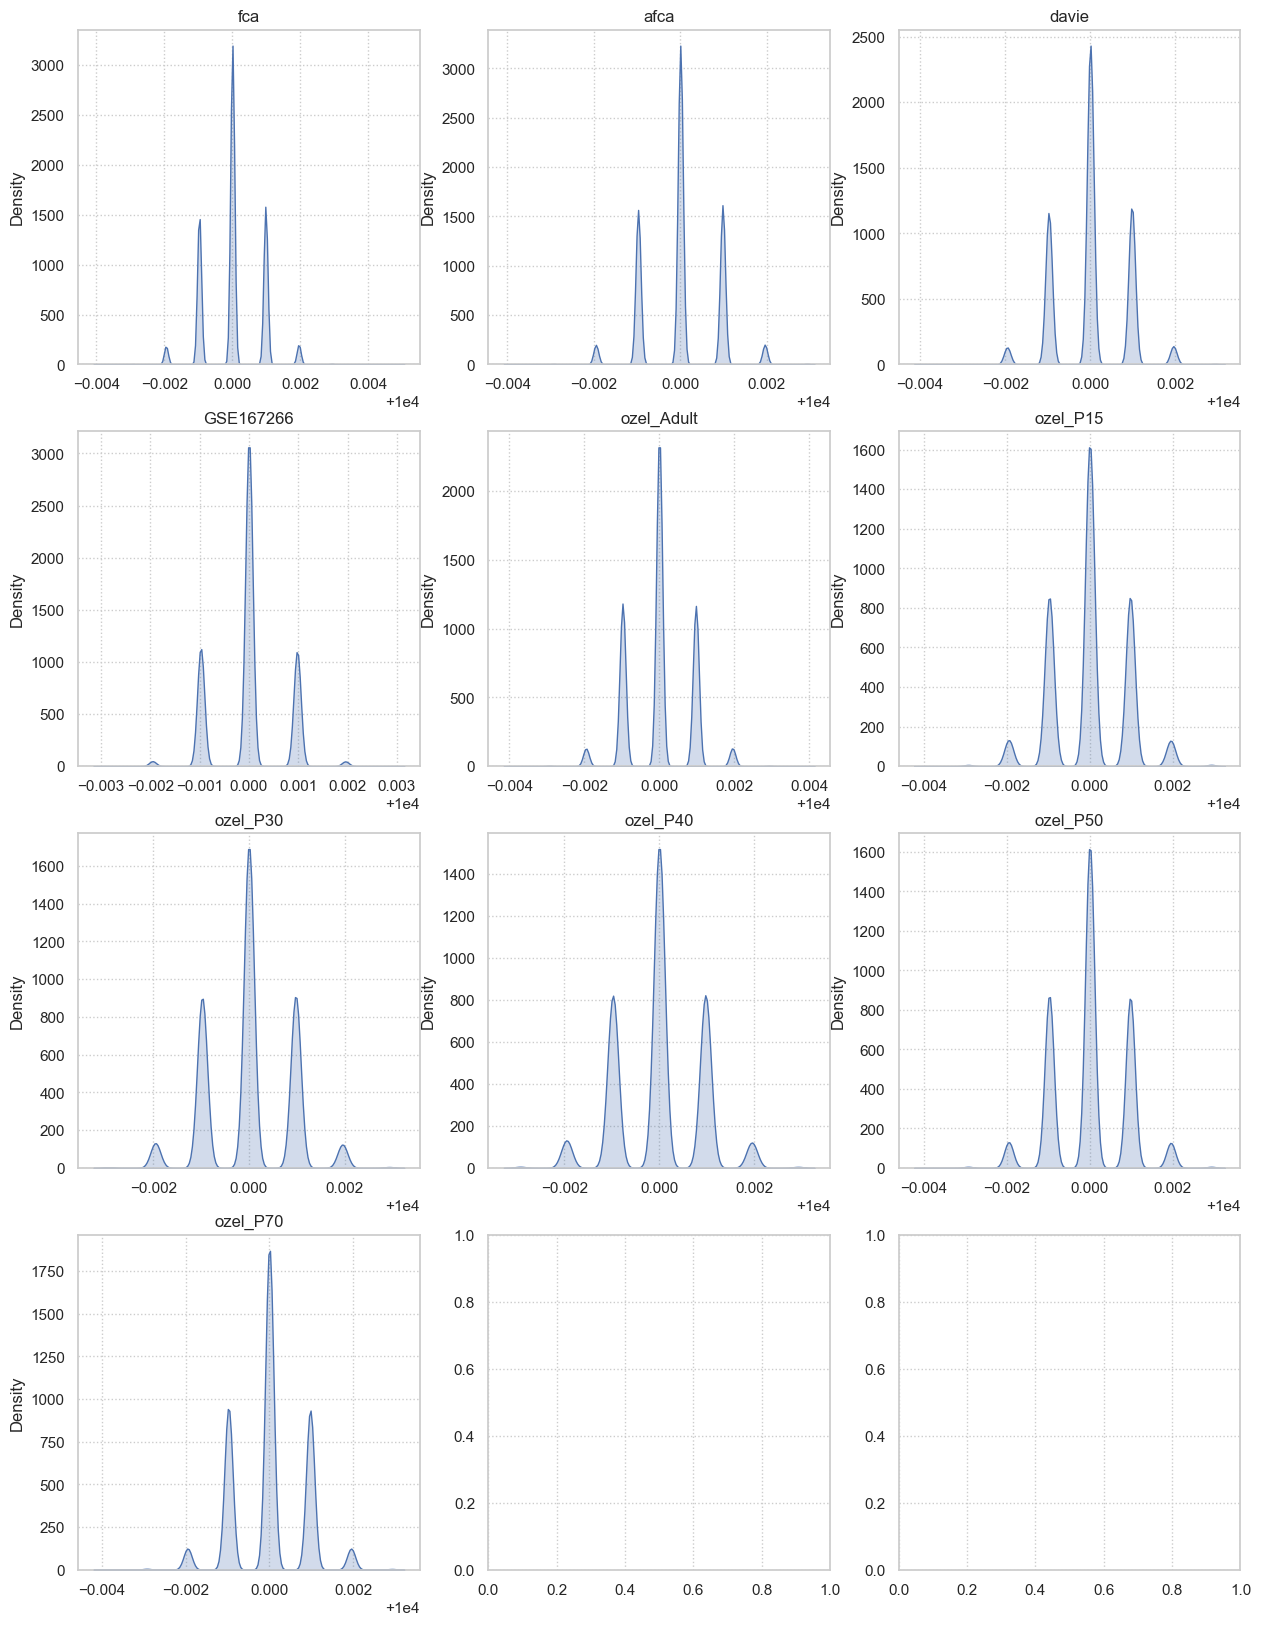

In [13]:
grid_kdeplots(anndata, lambda d: d.layers["expm1"].sum(axis=1))

## Mitochondrial gene percentage

/var/folders/0q/f6m0jdfn3jj2csvx8qp84ppw0000gn/T/ipykernel_77914/518125104.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(arr, fill=True,
/var/folders/0q/f6m0jdfn3jj2csvx8qp84ppw0000gn/T/ipykernel_77914/518125104.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(arr, fill=True,


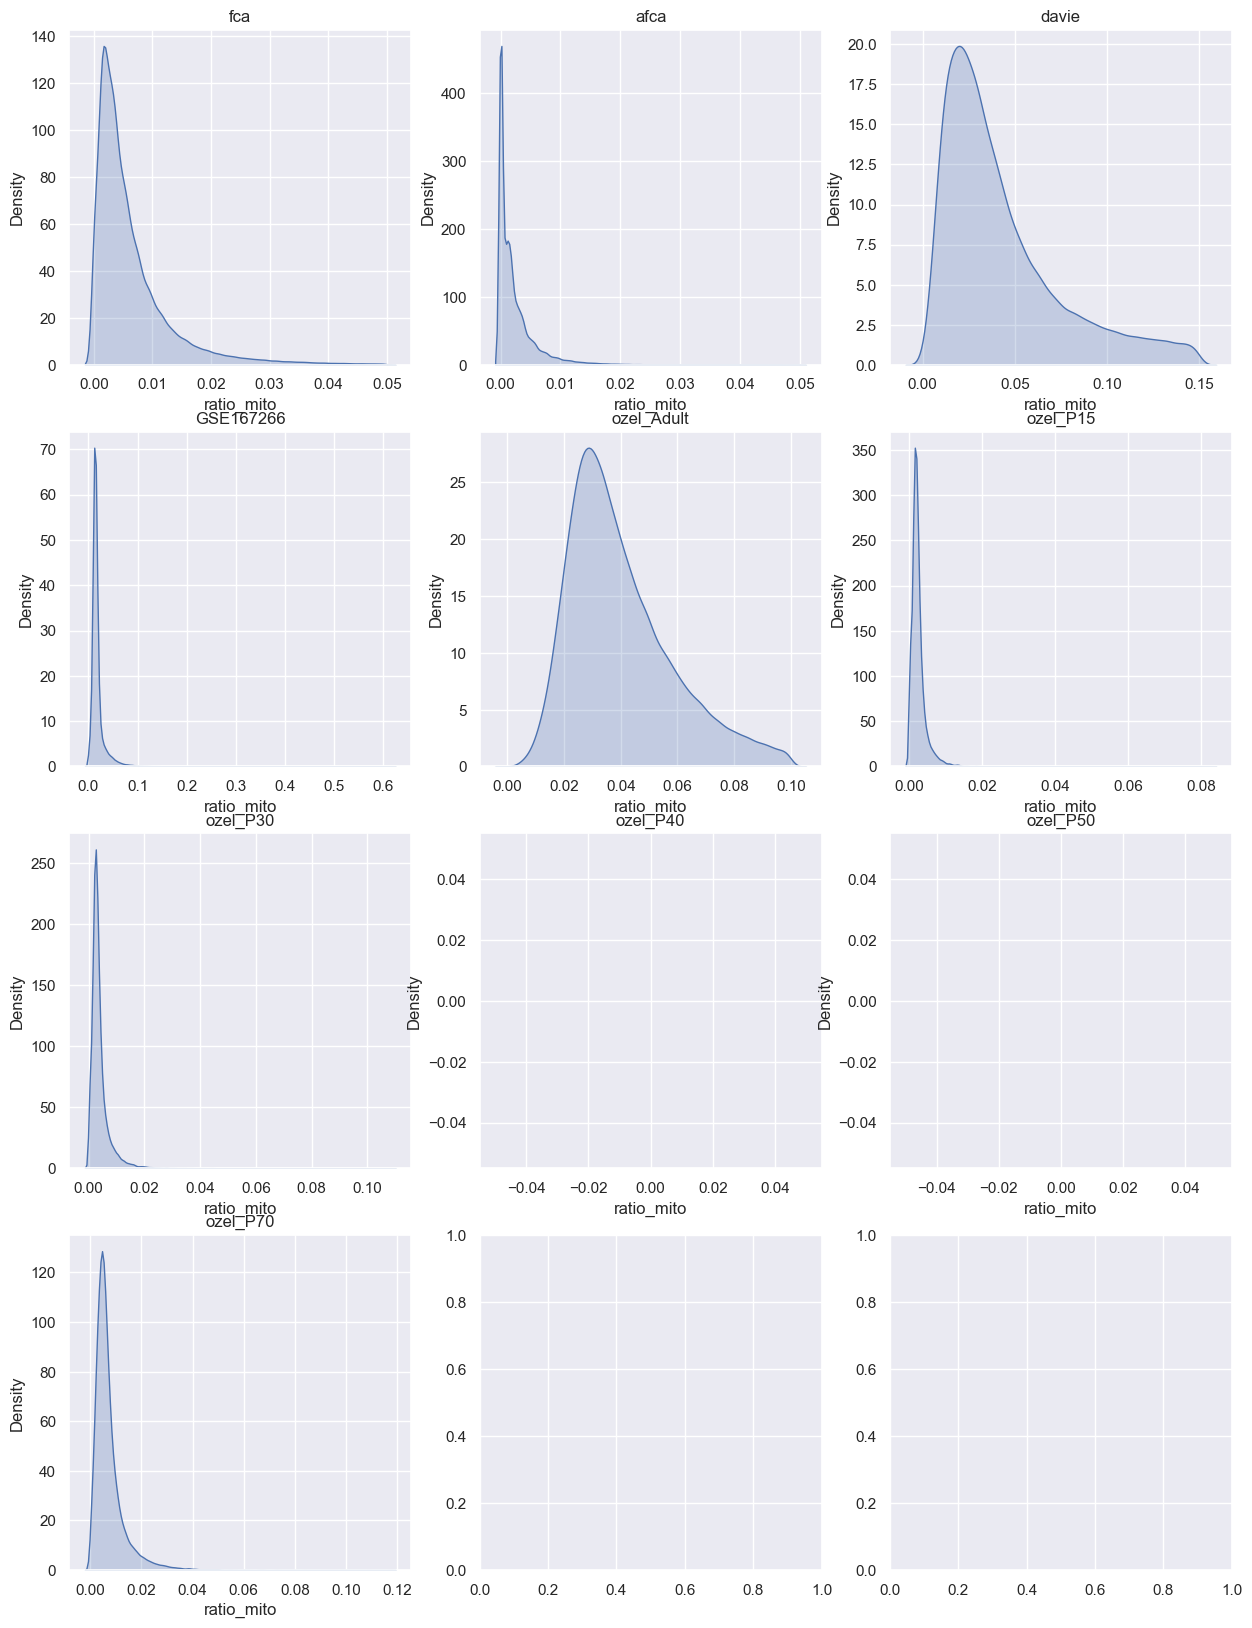

In [ ]:
grid_kdeplots(anndata, lambda d: d.obs.ratio_mito)

## 1. Filter by fraction of mitochondrial genes

In [ ]:
anndata_f0 = { k: v.copy() for k,v in anndata.items() }

In [ ]:
anndata = {
    k: v[v.obs.ratio_mito <= RATIO_MITO_THRES] for k,v in anndata.items()
}
for k,v in anndata.items():
    print(k, v.shape, v.shape[0] / anndata_f0[k].shape[0])

NameError: name 'anndata_f0' is not defined

/var/folders/0q/f6m0jdfn3jj2csvx8qp84ppw0000gn/T/ipykernel_87407/518125104.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(arr, fill=True,
/var/folders/0q/f6m0jdfn3jj2csvx8qp84ppw0000gn/T/ipykernel_87407/518125104.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(arr, fill=True,


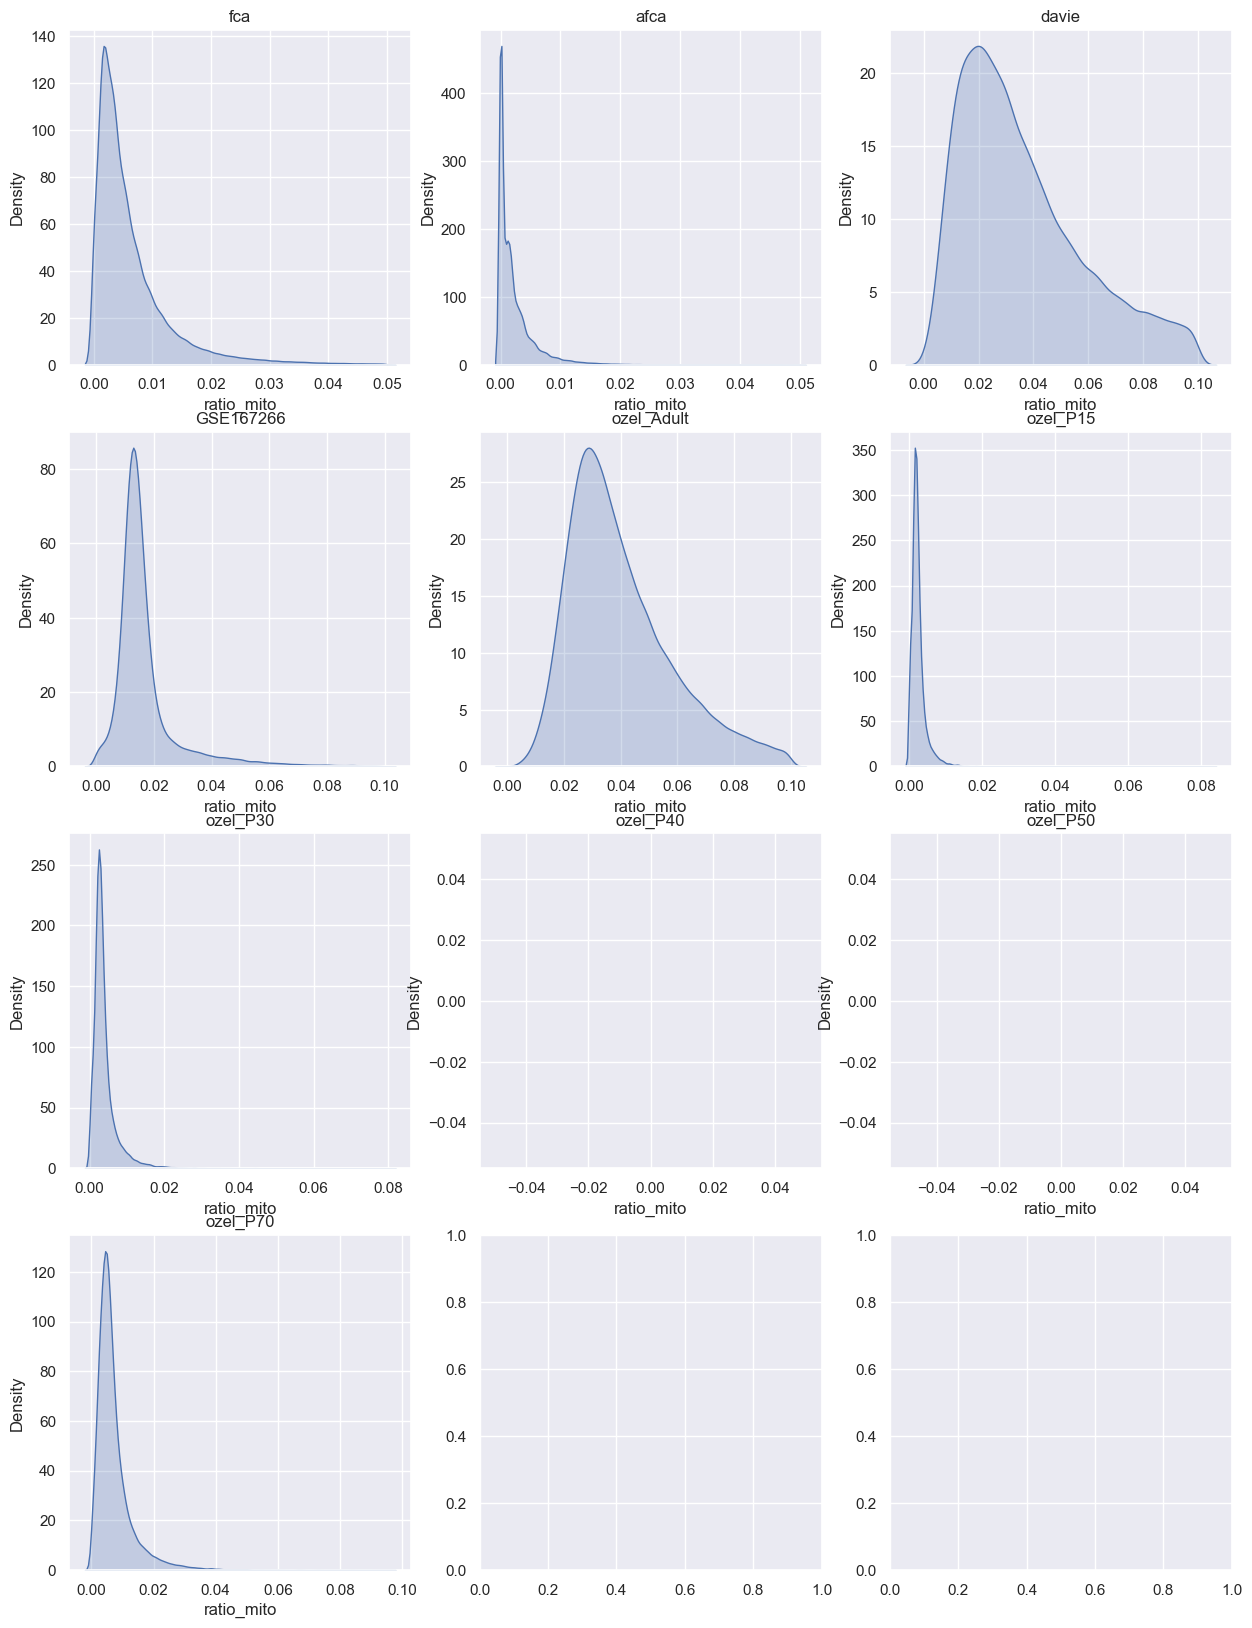

In [ ]:
grid_kdeplots(anndata, lambda d: d.obs.ratio_mito)

## 2. Filter out genes and cells with minimum expression

In [ ]:
anndata_f1 = { k: v.copy() for k,v in anndata.items() }

In [ ]:
[ sc.pp.filter_genes(d, min_cells=1) for d in anndata.values() ]

for k,v in anndata.items():
    print(k, v.shape, f"{v.shape[1]} of {anndata_f1[k].shape[1]} =", 
          round(v.shape[1] / anndata_f1[k].shape[1], 5))

/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/opt/homebrew/anaconda3/envs/flyformer/lib/pytho

fca (506660, 16366) 16366 of 16366 = 1.0
afca (566254, 15965) 15965 of 15992 = 0.99831
davie (109042, 11652) 11652 of 11652 = 1.0
GSE167266 (68388, 11582) 11582 of 11590 = 0.99931
ozel_Adult (109743, 2000) 2000 of 2000 = 1.0
ozel_P15 (31018, 2000) 2000 of 2000 = 1.0
ozel_P30 (35757, 2000) 2000 of 2000 = 1.0
ozel_P40 (24084, 2000) 2000 of 2000 = 1.0
ozel_P50 (31340, 2000) 2000 of 2000 = 1.0
ozel_P70 (43738, 2000) 2000 of 2000 = 1.0


# 3. Write processed loom files

In [15]:
outdir = f"./processed_loom_files/normalized_e4_log1p_mito{RATIO_MITO_THRES}"
os.makedirs(outdir, exist_ok=True)
for key, data in anndata.items():
    processed_loom = f"{outdir}/{key}.loom"
    if os.path.isfile(processed_loom):
        print("File already exists!. Make sure you want to override")
    else:
        print("Writing: ", processed_loom)
        data.write_loom(processed_loom)

Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/fca.loom
Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/afca.loom
Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/davie.loom
Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/GSE167266.loom
Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/ozel_Adult.loom
Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/ozel_P15.loom
Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/ozel_P30.loom
Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/ozel_P40.loom
Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/ozel_P50.loom
Writing:  ./processed_loom_files/normalized_e4_log1p_mito0.1/ozel_P70.loom


# 2. Filter protein-coding genes and (re)calculate QC metrics

## Build token dictionary (pickle)

## Filter protein-coding genes and QC metrics

In [30]:
adata_bk = adata.copy()
print("Number of genes present in dataset:", adata.n_vars)
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.calculate_qc_metrics(adata, inplace=True)
print("Number of genes present in any cell:", adata.n_vars)
adata = adata[:, adata.var_names.isin(PROTEIN_CODING_GENES)]
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.calculate_qc_metrics(adata, inplace=True)
print("Number of protein genes:", adata.n_vars)

Number of genes present in dataset: 2000


/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Number of genes present in any cell: 2000


/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Number of protein genes: 1683


/opt/homebrew/anaconda3/envs/flyformer/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 3. Filter by total and mitochondrial counts (within mean ± 3 * std)

In [31]:
print(f"Total number of cells without filtering: {adata.n_obs}")
filtered = filter_by_std(adata, "total_counts")
print(f"Number of cells after total count filter: {filtered.n_obs}")
filtered = filter_by_std(filtered, "total_counts_mt")
print(f"Number of cells after mitochondrial count filter: {filtered.n_obs}")
adata = filtered.copy()

Total number of cells without filtering: 109743
Mean 378.6700134277344   Standard deviation 56.099998474121094
Number of cells after total count filter: 107914
Mean 89.36   Standard deviation 71.92
Number of cells after mitochondrial count filter: 105969


In [34]:
n_within_model_input_size = sum(n_genes_by_counts <= MODEL_INPUT_SIZE)
print("Number of cells fully represented by model input size:",
      n_within_model_input_size)
print("Fraction of cells fully represented by model input size:",
      n_within_model_input_size / len(n_genes_by_counts))

Number of cells fully represented by model input size: 105969
Fraction of cells fully represented by model input size: 1.0


## Plot number of cells expressing each gene (protein coding)

count     2000.000000
mean     19131.259000
std       7789.471137
min        125.000000
25%      13417.250000
50%      22207.000000
75%      25112.250000
max      31018.000000
dtype: float64


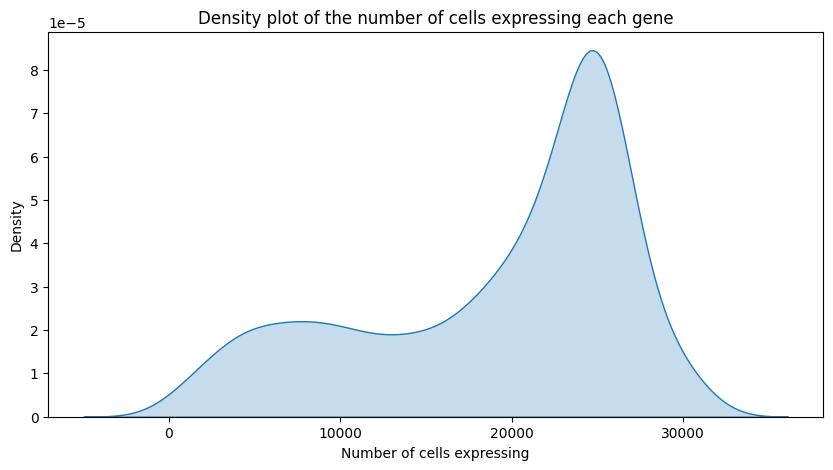

In [25]:
nonzero_mask = adata.X > 0

# Count number of cells expressing each gene
counts_per_gene = np.sum(nonzero_mask, axis=0)

# Convert to 1D array (needed for some versions of matplotlib)
counts_per_gene = np.squeeze(np.asarray(counts_per_gene))
print(pd.Series(counts_per_gene).describe())

# Plot the density using seaborn
plt.figure(figsize=(10, 5))
sns.kdeplot(counts_per_gene, fill=True)
plt.xlabel("Number of cells expressing")
plt.ylabel("Density")
plt.title("Density plot of the number of cells expressing each gene")
plt.show()

# 4. Discretize gene expression values

In [19]:
with open("./normalized_e4_log1p_mito0.1__no_ozelP.pickle", "rb") as fp:
    tdigests = pickle.load(fp)

print("Number of genes in TDigests:", len(tdigests.keys()))

Number of genes in TDigests: 16509


In [33]:
print_cell_and_gene_counts(anndata)

Total number of cells in 10 datasets: 1526024
Total number of genes in 10 datasets: 13094


In [24]:
tdigest_coding = { k: v for k, v in tdigests.items() if k in PROTEIN_CODING_GENES }
print(len(tdigest_coding.keys()))

12921


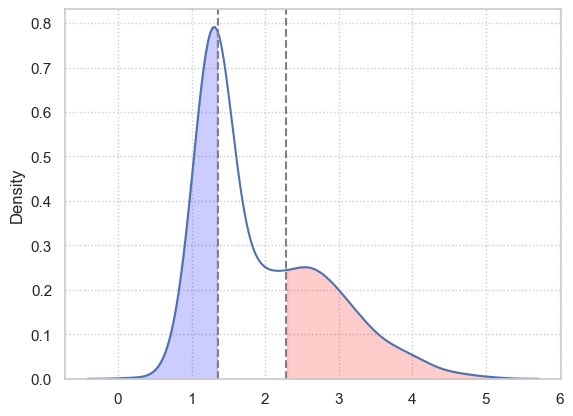

In [67]:
tdigest = tdigest_coding[list(tdigest_coding.keys())[0]]
samples = [ tdigest.percentile(np.random.uniform(0, 100)) for _ in range(1000) ]

ax = sns.kdeplot(samples)
x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
x_thresholds = [ tdigest.percentile(thres) for thres in PERCENTILE_THRESHOLDS ]
for x_thres in x_thresholds:
    plt.axvline(x_thres, color="gray", linestyle="--")

ax.fill_between(x, 0, y, where = x < x_thresholds[0], color="blue", alpha=0.2)
ax.fill_between(x, 0, y, where = x > x_thresholds[-1], color="red", alpha=0.2)

# 5. Analysis on protein coding genes only

In [ ]:
# anndata_bk = { k: v.copy() for k, v in anndata.items() }
anndata = { k: v[:, v.var_names.isin(PROTEIN_CODING_GENES)] \
            for k, v in anndata.items()}
print_cell_and_gene_counts(anndata)
# grid_kdeplots(anndata, lambda d: d.layers["expm1"].sum(axis=1))

Total number of cells in 10 datasets: 1536403
Total number of genes in 10 datasets: 13094


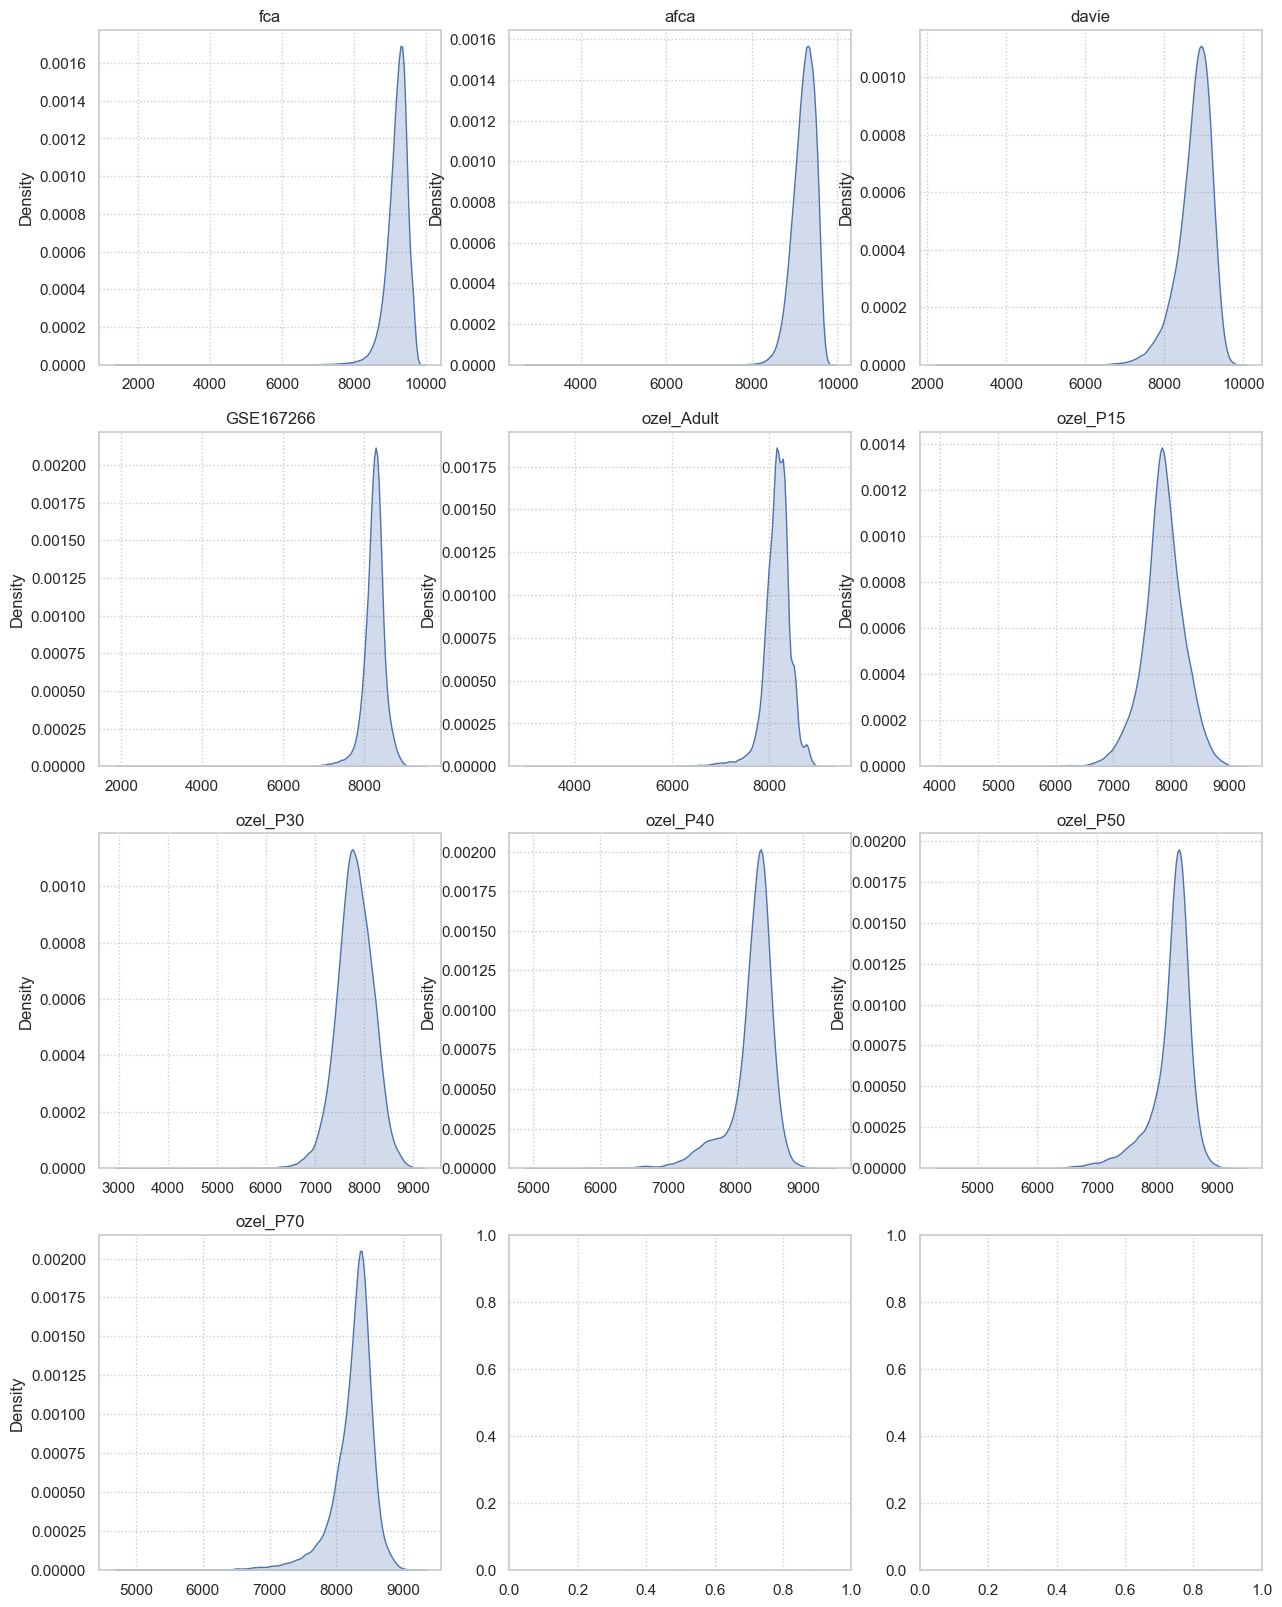

In [ ]:
grid_kdeplots(anndata, lambda d: d.X.expm1().sum(axis=1))

In [ ]:
for k, d in anndata.items():
    X_expm1 = d.X.expm1()
    d.X = None
    d.X = X_expm1
    sc.pp.normalize_total(d, target_sum=1e4)
    sc.pp.log1p(d)

fca


ValueError: could not convert integer scalar

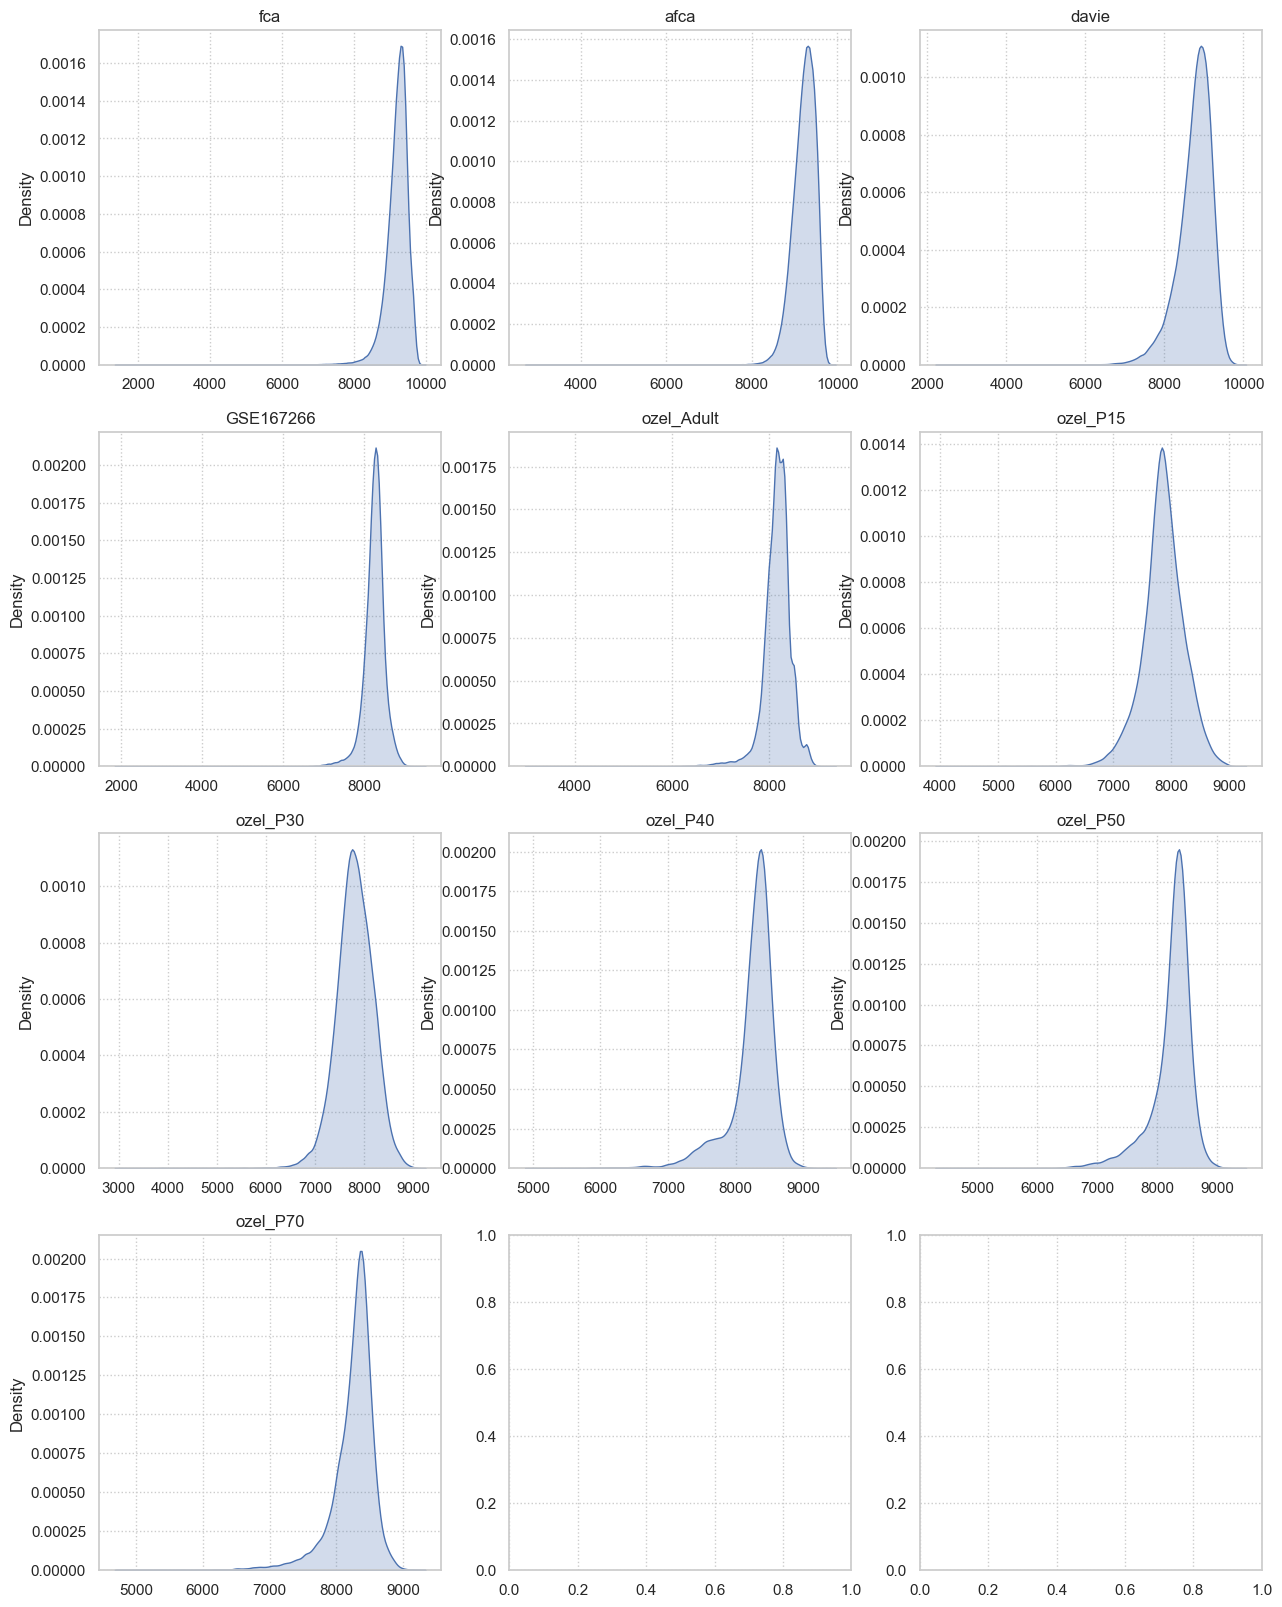

In [ ]:
grid_kdeplots(anndata, lambda d: d.X.expm1().sum(axis=1))